# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
path = '/home/ubuntu/data/training/keras/'


import numpy as np
import theano

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Download data and generate sequences

Download quijote from guttenberg project


wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = set(text)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


('corpus length:', 2198927)
('total chars:', 80)


In [3]:
print indices_char

{0: '\x81', 1: '@', 2: '\x89', 3: '\xad', 4: '\xba', 5: '\n', 6: '\r', 7: '\x91', 8: '\x93', 9: '\xef', 10: '\x9a', 11: '/', 12: '\xa1', 13: ' ', 14: '#', 15: ')', 16: '%', 17: '$', 18: "'", 19: '\xa9', 20: '(', 21: '\xab', 22: '*', 23: '-', 24: ',', 25: '\xaf', 26: '.', 27: '1', 28: '0', 29: '\xb3', 30: '2', 31: '5', 32: '4', 33: '7', 34: '6', 35: '9', 36: '8', 37: '\xbb', 38: ':', 39: '\xbc', 40: '\xbf', 41: '?', 42: '!', 43: '\xc3', 44: '\xc2', 45: '\xa0', 46: '\x8d', 47: '3', 48: '\xb9', 49: '"', 50: '[', 51: ']', 52: ';', 53: '\xb1', 54: 'a', 55: 'c', 56: 'b', 57: 'e', 58: 'd', 59: 'g', 60: 'f', 61: 'i', 62: 'h', 63: 'k', 64: 'j', 65: 'm', 66: 'l', 67: 'o', 68: 'n', 69: 'q', 70: 'p', 71: 's', 72: 'r', 73: 'u', 74: 't', 75: 'w', 76: 'v', 77: 'y', 78: 'x', 79: 'z'}


In [5]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(300, len(text) - maxlen, step): #Start in line 30 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print sentences[4996], '-', next_chars[4996]

('nb sequences:', 732869)
e nombre el río taj - o


## Train the model

In [6]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
('X shape: ', (732869, 20, 80))
('y shape: ', (732869, 80))


In [7]:
print(X[0])
print(y[0])

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False]


In [8]:
#Export sequiences to hdf5 to model in torch

print('Vectorization...')
X_num = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.uint8)
y_num = np.zeros(len(sentences), dtype=np.uint8)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X_num[i, t, char_indices[char]] = 1
    y_num[i] = char_indices[next_chars[i]]

print('X shape: ',X_num.shape)
print('y shape: ',y_num.shape)    
                 


Vectorization...
('X shape: ', (732869, 20, 80))
('y shape: ', (732869,))


In [9]:
print X_num[2], y_num[2]

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]] 57


In [10]:
#Save depurated characters to hdf5
import h5py

hdf5_f = h5py.File(path + "sequences20_quijote.hdf5",mode='a')

if "X" in hdf5_f:
    del hdf5_f["X"]
hdf5_f.create_dataset("X", data = X_num) 

if "y" in hdf5_f:
    del hdf5_f["y"]
hdf5_f.create_dataset("y", data = y_num)

hdf5_f.close() 

In [11]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM


print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(512, return_sequences=True)(seq_prev_input)
dp1 = Dropout(0.25)(forwards1)

forwards2 = LSTM(512, return_sequences=False)(dp1)
dp2 = Dropout(0.5)(forwards2)

output = Dense(len(chars), activation='softmax')(dp2)

model1 = Model(input=seq_prev_input, output=output)
model1.summary()

# try using different optimizers and different optimizer configs
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Using Theano backend.


Build model 1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 20, 80)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 20, 512)       1214464     prev[0][0]                       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 20, 512)       0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 512)           2099200     dropout_1[0][0]                  
_____________________________________________________________________________

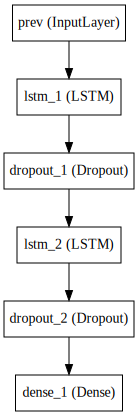

In [12]:
#Print the model
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [ ]:
#Fit model
history = model1.fit(X[:600000], y[:600000], batch_size=256, nb_epoch=30,
           validation_data=(X[600000:], y[600000:]))



In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [ ]:
#Save model
'''
model_name = 'text_generation_model1'

json_string = model1.to_json()
open(path + 'models/mdl_' + model_name + '.json', 'w').write(json_string)
model1.save_weights(path + 'models/w_' + model_name + '.h5')
'''

## Evaluate model

In [3]:
# Load model
from keras.models import model_from_json

model_name = 'text_generation_model1'

model1 = model_from_json(open(path + 'models/mdl_' + model_name + '.json').read())
model1.load_weights(path + 'models/w_' + model_name + '.h5')

In [ ]:
maxlen = 20

def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print('\n\nDIVERSITY: ',diversity,'\n')
    print(sentence_init + generated)


In [12]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de lo que sucedió a'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de allí a poco come'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


('\n\nDIVERSITY: ', 0.2, '\n')
mire vuestra merced de parecer que el mundo se ha de aquí a su ama, y el cura se le pasaba de la manera, que no se le pareció que está en el mundo de la vida, que es la mayor y me pareció que estaba de mi casa, y el que está en el mundo y a la señora dulcinea del toboso y el caballero de la triste figura, y el caballero de la triste figura, que era la venta la duquesa de la caballería, que es lo que se le dije
('\n\nDIVERSITY: ', 0.5, '\n')
mire vuestra merced parece, pues, la cual es mejor que se entre las manos y de cabeza de parecer al principio en el cuerpo, y con esto le dijo:

-señor don quijote, y el cura y el mal tal de la mancha, por la cual se le dijese que su amo de más se lo hayan.

-por esto se puede ser de los de las mismas cosas más a su ama. si estaba diciendo que estaba de tanto camino para ser una grande amiga de la andante caba
('\n\nDIVERSITY: ', 1, '\n')
mire vuestra merced luego, que de aquel alitado rico cuándo
visto, y vino en su c